In [2]:
import numpy as np
from scipy.optimize import minimize

class DroneRaceSEIBR:
    def __init__(self, num_drones, num_waypoints, dt, max_speed, collision_distance):
        self.num_drones = num_drones
        self.num_waypoints = num_waypoints
        self.dt = dt
        self.max_speed = max_speed
        self.collision_distance = collision_distance
        
        self.gate_positions = np.array([
            [-1.0, 0, 1.0],
            [-2.0, -1.0, 1.0],
            [-0.5, -1.8, 1.0],
            [1.0, -0.75, 1]
        ])
        
        self.track_min = np.min(self.gate_positions, axis=0) - 1
        self.track_max = np.max(self.gate_positions, axis=0) + 1
        
    def initialize_drones(self, original_init_pos, margin=0.5, altitude=1.0, max_offset=0.15):
        drone_positions = {}
        angle_step = 2 * np.pi / self.num_drones
        radius = margin * self.num_drones / (2 * np.pi)
        
        for i in range(self.num_drones):
            angle = i * angle_step
            x = original_init_pos[0] + radius * np.cos(angle)
            y = original_init_pos[1] + radius * np.sin(angle)
            x += np.random.uniform(-max_offset, max_offset)
            y += np.random.uniform(-max_offset, max_offset)
            z = np.random.uniform(0, altitude)
            drone_positions[f"drone_{i}"] = np.array([x, y, z])
        
        return drone_positions

    def objective(self, waypoints, start_pos, other_waypoints):
        trajectory = np.vstack([start_pos, waypoints.reshape(-1, 3)])
        progress = self.calculate_progress(trajectory)
        collision_penalty = self.calculate_collision_penalty(waypoints, other_waypoints)
        final_gate_distance = np.linalg.norm(trajectory[-1] - self.gate_positions[-1])
        return -progress + collision_penalty + 5 * final_gate_distance

    def calculate_progress(self, trajectory):
        progress = 0
        for i, gate_pos in enumerate(self.gate_positions):
            distances = np.linalg.norm(trajectory - gate_pos, axis=1)
            progress += (i + 1) * np.exp(-np.min(distances))
        
        # Add extra weight to the final gate
        final_gate_distance = np.linalg.norm(trajectory[-1] - self.gate_positions[-1])
        progress += 10 * np.exp(-final_gate_distance)
        
        return progress

    def calculate_collision_penalty(self, waypoints, other_waypoints):
        penalty = 0
        for other_wp in other_waypoints:
            distances = np.linalg.norm(waypoints.reshape(-1, 3) - other_wp.reshape(-1, 3), axis=1)
            penalty += np.sum(np.maximum(0, self.collision_distance - distances))
        return penalty * 10  # Increase the weight of collision penalty

    def optimize_waypoints(self, start_pos, other_waypoints):
        bounds = [(self.track_min[j], self.track_max[j]) for _ in range(self.num_waypoints) for j in range(3)]
        
        # Generate initial random waypoints correctly
        low = np.tile(self.track_min, (self.num_waypoints, 1))
        high = np.tile(self.track_max, (self.num_waypoints, 1))
        initial_waypoints = np.random.uniform(low=low, high=high, size=(self.num_waypoints, 3)).flatten()
        
        result = minimize(
            lambda x: self.objective(x, start_pos, other_waypoints),
            initial_waypoints,
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 200, 'ftol': 1e-6}
        )
        
        return result.x.reshape(-1, 3)

    def run_se_ibr(self, initial_positions, num_iterations=10):
        waypoints = {}
        for drone_id in initial_positions.keys():
            low = np.tile(self.track_min, (self.num_waypoints, 1))
            high = np.tile(self.track_max, (self.num_waypoints, 1))
            waypoints[drone_id] = np.random.uniform(low=low, high=high, size=(self.num_waypoints, 3))
        
        for _ in range(num_iterations):
            for drone_id, start_pos in initial_positions.items():
                other_waypoints = [wp for id, wp in waypoints.items() if id != drone_id]
                waypoints[drone_id] = self.optimize_waypoints(start_pos, other_waypoints)
        
        return waypoints

# Example usage:
num_drones = 4
num_waypoints = 5
dt = 0.1
max_speed = 2.0
collision_distance = 1.0

race = DroneRaceSEIBR(num_drones, num_waypoints, dt, max_speed, collision_distance)
initial_positions = race.initialize_drones(original_init_pos=[-1.0, 0, 1.0])
final_waypoints = race.run_se_ibr(initial_positions)

# Print final waypoints
for drone_id, waypoints in final_waypoints.items():
    print(f"{drone_id} final waypoint: {waypoints[-1]}")

# Print distance to final gate for each drone
final_gate = race.gate_positions[-1]
print("\nDistance to final gate:")
for drone_id, waypoints in final_waypoints.items():
    distance = np.linalg.norm(waypoints[-1] - final_gate)
    print(f"{drone_id}: {distance:.2f}")

drone_0 final waypoint: [ 0.42882685 -0.16973294  1.17616421]
drone_1 final waypoint: [-0.44602544 -0.65146581  1.12955124]
drone_2 final waypoint: [ 1.00004225 -0.75001056  1.000007  ]
drone_3 final waypoint: [ 1.11477712 -0.86748614  0.96973576]

Distance to final gate:
drone_0: 0.83
drone_1: 1.46
drone_2: 0.00
drone_3: 0.17



drone_0 waypoints and yaws:
Position: [-0.51689066 -0.07766326  0.95991451], Yaw: -0.42
Position: [-0.39014169 -0.13393023  0.96327544], Yaw: -0.42
Position: [-0.26022847 -0.19134998  0.9666843 ], Yaw: -0.42
Position: [-0.12594722 -0.2510223   0.97025572], Yaw: -0.42
Position: [ 0.01528083 -0.31357243  0.97397884], Yaw: -0.42
Position: [ 0.16394673 -0.37941336  0.9779035 ], Yaw: -0.42
Position: [ 0.32004841 -0.4486658   0.98203345], Yaw: -0.42
Position: [ 0.48299151 -0.52088482  0.98634378], Yaw: -0.42
Position: [ 0.65212195 -0.59576086  0.99079749], Yaw: -0.42
Position: [ 0.8247959  -0.67239616  0.99537743], Yaw: -0.42
Position: [ 1.00000018 -0.75000008  0.99999977], Yaw: -0.42

drone_1 waypoints and yaws:
Position: [-1.0142554   0.48217637  1.06130819], Yaw: -0.55
Position: [-0.84541402  0.3790384   1.05615356], Yaw: -0.55
Position: [-0.67311793  0.27321608  1.05095962], Yaw: -0.55
Position: [-0.49489623  0.16473856  1.04543688], Yaw: -0.55
Position: [-0.30779258  0.04972179  1.0398

In [2]:
import numpy as np
from scipy.optimize import minimize

class DroneRacePlanner:
    def __init__(self, num_drones, num_waypoints, gate_positions, dt=0.1):
        self.num_drones = num_drones
        self.num_waypoints = num_waypoints
        self.gate_positions = np.array(gate_positions)
        self.dt = dt  # Time step for integration
        
    def initialize_drones(self, start_pos, radius=0.5, max_offset=0.1):
        drone_positions = {}
        angle_step = 2 * np.pi / self.num_drones
        
        for i in range(self.num_drones):
            angle = i * angle_step
            x = start_pos[0] + radius * np.cos(angle)
            y = start_pos[1] + radius * np.sin(angle)
            x += np.random.uniform(-max_offset, max_offset)
            y += np.random.uniform(-max_offset, max_offset)
            z = start_pos[2] + np.random.uniform(-max_offset, max_offset)
            drone_positions[f"drone_{i}"] = np.array([x, y, z])
        
        return drone_positions

    def objective(self, reference_values, start_pos):
        trajectory = self.calculate_trajectory(start_pos, reference_values)
        gates_passed = self.calculate_gates_passed(trajectory)
        smoothness_penalty = self.calculate_smoothness_penalty(reference_values)
        final_gate_distance = np.linalg.norm(trajectory[-1] - self.gate_positions[-1])
        return -gates_passed + 0.1 * smoothness_penalty + 5 * final_gate_distance

    def calculate_trajectory(self, start_pos, reference_values):
        trajectory = [start_pos]
        current_pos = start_pos
        velocity = np.zeros(3)
        for ref in reference_values.reshape(-1, 3):
            velocity += ref * self.dt  # Update velocity based on reference (acceleration)
            current_pos = current_pos + velocity * self.dt  # Update position based on velocity
            trajectory.append(current_pos)
        return np.array(trajectory)

    def calculate_gates_passed(self, trajectory):
        gates_passed = 0
        for gate_pos in self.gate_positions:
            distances = np.linalg.norm(trajectory - gate_pos, axis=1)
            if np.min(distances) < 0.5:  # Consider a gate passed if within 0.5 units
                gates_passed += 1
        return gates_passed

    def calculate_smoothness_penalty(self, reference_values):
        return np.sum(np.diff(reference_values.reshape(-1, 3), axis=0)**2)

    def optimize_reference_values(self, start_pos):
        bounds = [(-1, 1) for _ in range(self.num_waypoints * 3)]
        
        initial_reference_values = np.zeros((self.num_waypoints, 3))
        for i in range(self.num_waypoints):
            t = (i + 1) / (self.num_waypoints + 1)
            initial_reference_values[i] = (self.gate_positions[-1] - start_pos) * t / (self.num_waypoints * self.dt)
        initial_reference_values = np.clip(initial_reference_values, -1, 1).flatten()
        
        result = minimize(
            lambda x: self.objective(x, start_pos),
            initial_reference_values,
            method='SLSQP',
            bounds=bounds,
            options={'maxiter': 1000, 'ftol': 1e-6}
        )
        
        return np.clip(result.x.reshape(-1, 3), -1, 1)

    def calculate_yaw(self, current_pos, next_pos):
        direction = next_pos - current_pos
        yaw = np.arctan2(direction[1], direction[0])
        return yaw

    def plan_trajectories(self, initial_positions):
        trajectories = {}
        
        for drone_id, start_pos in initial_positions.items():
            reference_values = self.optimize_reference_values(start_pos)
            trajectory = self.calculate_trajectory(start_pos, reference_values)
            
            # Calculate yaw for each waypoint
            yaws = [self.calculate_yaw(trajectory[i], trajectory[i+1]) for i in range(len(trajectory)-1)]
            yaws.append(yaws[-1])  # Use the last yaw for the final waypoint
            
            trajectories[drone_id] = {
                'reference_values': reference_values,
                'positions': trajectory,
                'yaws': yaws
            }
        
        return trajectories

# Example usage:
num_drones = 4
num_waypoints = 10
gate_positions = [
    [-1.0, 0, 1.0],
    [-2.0, -1.0, 1.0],
    [-0.5, -1.8, 1.0],
    [1.0, -0.75, 1.0]
]

planner = DroneRacePlanner(num_drones, num_waypoints, gate_positions)
initial_positions = planner.initialize_drones(start_pos=gate_positions[0])
trajectories = planner.plan_trajectories(initial_positions)

# Print reference values, positions, and yaws for each drone
for drone_id, trajectory in trajectories.items():
    print(f"\n{drone_id} reference values, positions, and yaws:")
    for ref, pos, yaw in zip(trajectory['reference_values'], trajectory['positions'], trajectory['yaws']):
        print(f"Reference: {ref}, Position: {pos}, Yaw: {yaw:.2f}")

# Print distance to final gate for each drone
final_gate = np.array(gate_positions[-1])
print("\nDistance to final gate:")
for drone_id, trajectory in trajectories.items():
    distance = np.linalg.norm(trajectory['positions'][-1] - final_gate)
    print(f"{drone_id}: {distance:.2f}")


drone_0 reference values, positions, and yaws:
Reference: [ 1.         -1.          0.06947178], Position: [-0.50817707  0.05818365  0.96703069], Yaw: -0.79
Reference: [ 1.         -1.          0.06754524], Position: [-0.49817707  0.04818365  0.96772541], Yaw: -0.79
Reference: [ 1.         -1.          0.06426576], Position: [-0.47817707  0.02818365  0.96909558], Yaw: -0.79
Reference: [ 1.         -1.          0.06037936], Position: [-0.44817707 -0.00181635  0.97110841], Yaw: -0.79
Reference: [ 1.         -1.          0.05637646], Position: [-0.40817707 -0.04181635  0.97372503], Yaw: -0.79
Reference: [ 1.         -1.          0.05238565], Position: [-0.35817707 -0.09181635  0.97690541], Yaw: -0.79
Reference: [ 1.         -1.          0.04838284], Position: [-0.29817707 -0.15181635  0.98060966], Yaw: -0.79
Reference: [ 1.         -1.          0.04449664], Position: [-0.22817707 -0.22181635  0.98479773], Yaw: -0.79
Reference: [ 1.         -1.          0.04121705], Position: [-0.14817707

In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

class DroneRacePlanner:
    def __init__(self, num_drones, gate_positions, grid_resolution=5, dt=0.1):
        self.num_drones = num_drones
        self.gate_positions = np.array(gate_positions)
        self.dt = dt
        self.current_gate = 0
        self.drone_states = {}
        self.trajectories = {}
        self.grid_resolution = grid_resolution
        self.precomputed_trajectories, self.grid_bounds = self.precompute_trajectories()

    def precompute_trajectories(self):
        precomputed = []
        grid_bounds = []
        for gate_idx in range(len(self.gate_positions) - 1):
            start_gate = self.gate_positions[gate_idx]
            end_gate = self.gate_positions[gate_idx + 1]
            
            # Create a grid of starting positions around the start gate
            x = np.linspace(start_gate[0] - 2, start_gate[0] + 2, self.grid_resolution)
            y = np.linspace(start_gate[1] - 2, start_gate[1] + 2, self.grid_resolution)
            z = np.linspace(start_gate[2] - 2, start_gate[2] + 2, self.grid_resolution)
            
            grid_bounds.append(((x[0], x[-1]), (y[0], y[-1]), (z[0], z[-1])))
            
            grid_trajectories = np.zeros((self.grid_resolution, self.grid_resolution, self.grid_resolution, 3))
            
            for i, xi in enumerate(x):
                for j, yi in enumerate(y):
                    for k, zi in enumerate(z):
                        start_pos = np.array([xi, yi, zi])
                        displacement = end_gate - start_pos
                        grid_trajectories[i, j, k] = displacement
            
            interpolator = RegularGridInterpolator((x, y, z), grid_trajectories)
            precomputed.append(interpolator)
        
        return precomputed, grid_bounds

    def clamp_position(self, position, gate_idx):
        bounds = self.grid_bounds[gate_idx]
        return np.clip(position, 
                       [bounds[0][0], bounds[1][0], bounds[2][0]],
                       [bounds[0][1], bounds[1][1], bounds[2][1]])

    def simple_trajectory(self, start_pos, end_pos, num_points=10):
        """
        Compute a simple trajectory from start to end position.
        """
        return np.linspace(start_pos, end_pos, num_points)

    def reset(self, initial_positions):
        self.current_gate = 0
        self.drone_states = {
            drone_id: {
                'position': pos,
                'velocity': np.zeros(3),
                'trajectory': None
            } for drone_id, pos in initial_positions.items()
        }
        self.trajectories = {drone_id: [] for drone_id in initial_positions}
        return self.get_state()

    def get_state(self):
        return {
            drone_id: {
                'position': state['position'],
                'velocity': state['velocity'],
                'current_gate': self.current_gate,
                'gate_position': self.gate_positions[self.current_gate]
            } for drone_id, state in self.drone_states.items()
        }

    def step(self):
        rewards = {}
        done = False

        for drone_id, state in self.drone_states.items():
            if state['trajectory'] is None or len(state['trajectory']) == 0:
                # Generate new trajectory
                start_pos = state['position']
                if self.current_gate < len(self.precomputed_trajectories):
                    interpolator = self.precomputed_trajectories[self.current_gate]
                    clamped_pos = self.clamp_position(start_pos, self.current_gate)
                    displacement = interpolator(clamped_pos)[0]
                    end_pos = start_pos + displacement
                else:
                    end_pos = self.gate_positions[-1]  # Move towards the last gate
                state['trajectory'] = self.simple_trajectory(start_pos, end_pos)

            # Move along trajectory
            new_position = state['trajectory'][0]
            state['trajectory'] = state['trajectory'][1:]
            
            # Update drone state
            state['velocity'] = (new_position - state['position']) / self.dt
            state['position'] = new_position
            
            # Calculate reward
            distance_to_gate = np.linalg.norm(new_position - self.gate_positions[min(self.current_gate, len(self.gate_positions)-1)])
            rewards[drone_id] = -distance_to_gate
            
            # Store trajectory
            self.trajectories[drone_id].append(new_position)

        # Check if all drones have passed the current gate
        if self.current_gate < len(self.gate_positions) and all(np.linalg.norm(state['position'] - self.gate_positions[self.current_gate]) < 0.5 
               for state in self.drone_states.values()):
            self.current_gate += 1
            if self.current_gate >= len(self.gate_positions):
                done = True

        next_state = self.get_state()
        info = {'trajectories': self.trajectories}

        return next_state, rewards, done, info

    def calculate_next_position(self, current_position, current_velocity, reference_value):
        next_velocity = current_velocity + reference_value * self.dt
        next_position = current_position + next_velocity * self.dt
        return next_position, next_velocity

In [4]:
num_drones = 2
gate_positions = [
    [-1.0, 0, 1.0],
    [-2.0, -1.0, 1.0],
    [-0.5, -1.8, 1.0],
    [1.0, -0.75, 1.0]
]

planner = DroneRacePlanner(num_drones, gate_positions)

initial_positions = {f"drone_{i}": np.array(gate_positions[0]) + np.random.uniform(-0.1, 0.1, 3) for i in range(num_drones)}
states = planner.reset(initial_positions)

max_steps = 1000
for step in range(max_steps):
    next_states, rewards, done, info = planner.step()
    states = next_states
    print (next_states['drone_1']['position'])
    if done:
        break

print(f"Completed in {step} steps")

[-1.06147758 -0.02585185  1.0969309 ]
[-1.16575785 -0.13409053  1.0861608 ]
[-1.27003812 -0.24232922  1.0753907 ]
[-1.37431839 -0.3505679   1.0646206 ]
[-1.47859866 -0.45880658  1.0538505 ]
[-1.58287893 -0.56704527  1.0430804 ]
[-1.68715919 -0.67528395  1.0323103 ]
[-1.79143946 -0.78352263  1.0215402 ]
[-1.89571973 -0.89176132  1.0107701 ]
[-2. -1.  1.]
[-2. -1.  1.]
[-1.66666667 -0.97222222  1.        ]
[-1.33333333 -0.94444444  1.        ]
[-1.         -0.91666667  1.        ]
[-0.66666667 -0.88888889  1.        ]
[-0.33333333 -0.86111111  1.        ]
[ 0.         -0.83333333  1.        ]
[ 0.33333333 -0.80555556  1.        ]
[ 0.66666667 -0.77777778  1.        ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.   -0.75  1.  ]
[ 1.  

Drone 1 final position: [-1.02273563  0.          1.96691937]


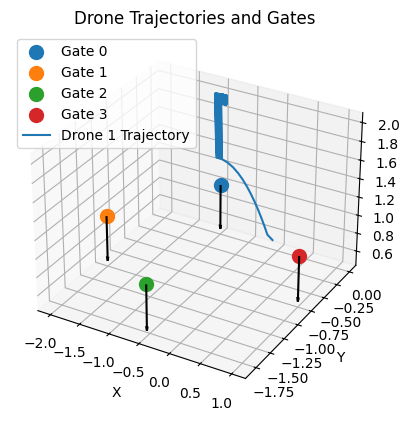

Drone 1 final position: [8.39330158e-04 1.10714978e+00 1.00000000e+00]


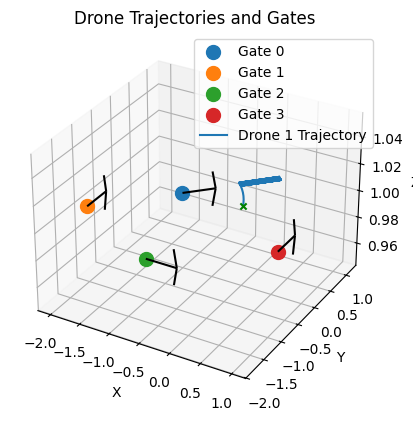

In [2]:
drones[0].trajectory

[array([-0.03826834,  0.09238795,  1.        ]),
 array([-0.08091514,  0.18283822,  1.        ]),
 array([-0.12805578,  0.27102983,  1.        ]),
 array([-0.17975918,  0.35662632,  1.        ]),
 array([-0.23603863,  0.439286  ,  1.        ]),
 array([-0.29684508,  0.51867476,  1.        ]),
 array([-0.36206414,  0.59448026,  1.        ]),
 array([-0.43151778,  0.66642603,  1.        ]),
 array([-0.35806492,  0.59856824,  1.        ]),
 array([-0.42752939,  0.67050355,  1.        ]),
 array([-0.35409147,  0.60262961,  1.        ]),
 array([-0.42356654,  0.67455467,  1.        ]),
 array([-0.35014329,  0.60666486,  1.        ]),
 array([-0.41962876,  0.67857987,  1.        ]),
 array([-0.34621991,  0.6106745 ,  1.        ]),
 array([-0.41571557,  0.68257966,  1.        ]),
 array([-0.34232085,  0.61465901,  1.        ]),
 array([-0.41182652,  0.68655451,  1.        ]),
 array([-0.33844569,  0.61861885,  1.        ]),
 array([-0.40796116,  0.69050487,  1.        ]),
 array([-0.33459397,

In [3]:
import numpy as np

class Drone:
    def __init__(self, position, max_speed, drone_id):
        self.position = np.array(position, dtype=float)
        self.max_speed = max_speed
        self.drone_id = drone_id
        self.current_gate_index = 0
        self.waypoints = []  # List of positional references
        self.path_history = [self.position.copy()]  # History of positions

    def update_position(self, dt):
        if self.waypoints:
            # Move towards the next waypoint
            target = self.waypoints[0]
            direction = target - self.position
            distance_to_target = np.linalg.norm(direction)
            if distance_to_target > 0:
                direction /= distance_to_target
                speed = min(self.max_speed, distance_to_target / dt)
                self.position += direction * speed * dt
            else:
                # Reached the waypoint
                self.position = target
                self.waypoints.pop(0)
            self.path_history.append(self.position.copy())

    def check_gate_passage(self, gates):
        gate = gates[self.current_gate_index]
        to_gate = gate.position - self.position
        distance_to_gate = np.linalg.norm(to_gate)
        passed_gate = np.dot(to_gate, gate.normal) < 0
        close_enough = distance_to_gate < gate.radius
        if passed_gate and close_enough:
            print(f"Drone {self.drone_id} passed through Gate {self.current_gate_index}")
            self.current_gate_index = (self.current_gate_index + 1) % len(gates)
            self.waypoints = []  # Clear waypoints to generate new ones




class Gate:
    def __init__(self, position, rpy, radius=0.5):
        self.position = np.array(position, dtype=float)
        self.radius = radius
        self.rpy = np.array(rpy, dtype=float)
        self.normal = self.compute_normal()

    def compute_normal(self):
        roll, pitch, yaw = self.rpy
        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll),  np.cos(roll)]
        ])
        Ry = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0,             1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        Rz = np.array([
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw),  np.cos(yaw), 0],
            [0,            0,           1]
        ])
        R = Rz @ Ry @ Rx
        original_normal = np.array([1, 0, 0])  # Gates facing positive x-axis
        rotated_normal = R @ original_normal
        rotated_normal /= np.linalg.norm(rotated_normal)
        return rotated_normal
    


def generate_waypoints(drone, drones, gates, waypoint_distance, safe_distance):
    gate = gates[drone.current_gate_index]
    path = []
    
    # Compute desired path to the gate
    to_gate = gate.position - drone.position
    distance_to_gate = np.linalg.norm(to_gate)
    num_waypoints = max(1, int(distance_to_gate / waypoint_distance))
    direction = to_gate / distance_to_gate if distance_to_gate > 0 else np.zeros(3)
    
    # Generate waypoints along the path to the gate
    for i in range(1, num_waypoints + 1):
        waypoint = drone.position + direction * waypoint_distance * i
        path.append(waypoint)
    
    # Adjust waypoints to avoid conflicts
    adjusted_path = adjust_waypoints(drone, path, drones, safe_distance)
    drone.waypoints = adjusted_path



def adjust_waypoints(drone, path, drones, safe_distance):
    adjusted_path = []
    for waypoint in path:
        adjusted_waypoint = waypoint.copy()
        for other_drone in drones:
            if other_drone.drone_id != drone.drone_id:
                # Check if other drone is near the waypoint
                distance = np.linalg.norm(other_drone.position - adjusted_waypoint)
                if distance < safe_distance:
                    # Adjust waypoint position to avoid collision
                    avoidance_direction = adjusted_waypoint - other_drone.position
                    if np.linalg.norm(avoidance_direction) > 0:
                        avoidance_direction /= np.linalg.norm(avoidance_direction)
                        adjustment = avoidance_direction * safe_distance
                        adjusted_waypoint = other_drone.position + adjustment
        adjusted_path.append(adjusted_waypoint)
    return adjusted_path

In [4]:
# Define gates with positions and orientations
gate_positions = np.array([
    [-1.0, 0, 1.0],
    [-2.0, -1.0, 1.0],
    [-0.5, -1.8, 1.0],
    [1.0, -0.75, 1.0]
])

gate_rpy = np.array([
    [0, 0, np.pi/4],
    [0, 0, np.pi/2],
    [0, 0, 0],
    [0, 0, np.pi/2]
])

gates = [Gate(position=pos, rpy=rpy) for pos, rpy in zip(gate_positions, gate_rpy)]

# Initialize drones
drones = [
    Drone(position=[0, 0, 1.0], max_speed=1.0, drone_id=1),
    Drone(position=[0.5, 0.5, 1.0], max_speed=1.0, drone_id=2),
    # Add more drones as needed
]

dt = 0.1  # Time step
simulation_time = 30  # Total simulation time
time_steps = int(simulation_time / dt)
waypoint_distance = 0.5  # Distance between waypoints
safe_distance = 0.5  # Minimum separation between drones

for _ in range(time_steps):
    # Generate waypoints if needed
    for drone in drones:
        if not drone.waypoints:
            generate_waypoints(drone, drones, gates, waypoint_distance, safe_distance)
    # Update positions
    for drone in drones:
        drone.update_position(dt)
        drone.check_gate_passage(gates)

Drone 1 passed through Gate 0
Drone 2 passed through Gate 0
Drone 1 passed through Gate 1
Drone 2 passed through Gate 1
Drone 1 passed through Gate 2
Drone 2 passed through Gate 2
Drone 1 passed through Gate 3
Drone 2 passed through Gate 3
Drone 1 passed through Gate 0
Drone 2 passed through Gate 0
Drone 1 passed through Gate 1
Drone 2 passed through Gate 1
Drone 1 passed through Gate 2
Drone 2 passed through Gate 2
Drone 1 passed through Gate 3
Drone 2 passed through Gate 3
Drone 1 passed through Gate 0
Drone 2 passed through Gate 0
Drone 1 passed through Gate 1
Drone 2 passed through Gate 1
Drone 1 passed through Gate 2
Drone 2 passed through Gate 2
Drone 1 passed through Gate 3
Drone 2 passed through Gate 3
Drone 1 passed through Gate 0
Drone 2 passed through Gate 0
Drone 1 passed through Gate 1
Drone 2 passed through Gate 1
Drone 1 passed through Gate 2
Drone 2 passed through Gate 2
Drone 1 passed through Gate 3


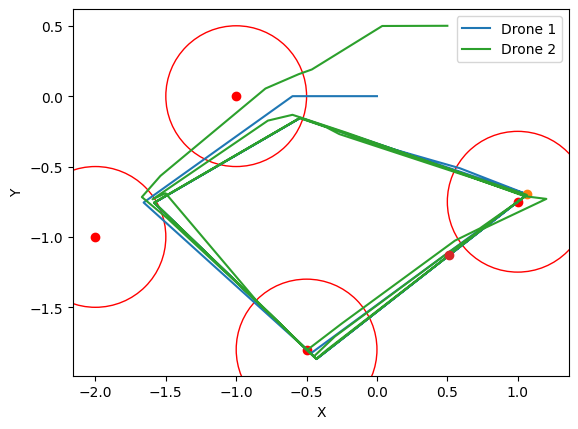

In [5]:
import matplotlib.pyplot as plt

def plot_drones(drones, gates):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    for gate in gates:
        circle = plt.Circle((gate.position[0], gate.position[1]), gate.radius, color='r', fill=False)
        ax.add_artist(circle)
        ax.plot(gate.position[0], gate.position[1], 'ro')
    for drone in drones:
        path = np.array(drone.path_history)
        ax.plot(path[:, 0], path[:, 1], label=f'Drone {drone.drone_id}')
        ax.plot(drone.position[0], drone.position[1], 'o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    plt.show()

# After simulation
plot_drones(drones, gates)